### Link: https://rubikscode.net/2018/12/17/implementing-gan-dcgan-with-python/

In [ ]:
import tensorflow as tf
print(tf.__version__)
%mkdir generated

2.7.0


## Helper class

In [ ]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt

class ImageHelper(object):
    def save_image(self, generated, epoch, directory):
        fig, axs = plt.subplots(5, 5)
        count = 0
        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(generated[count, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                count += 1
        fig.savefig("{}/{}.png".format(directory, epoch))
        plt.close()
        
    def makegif(self, directory):
        filenames = np.sort(os.listdir(directory))
        filenames = [ fnm for fnm in filenames if ".png" in fnm]
    
        with imageio.get_writer(directory + '/image.gif', mode='I') as writer:
            for filename in filenames:
                image = imageio.imread(directory + filename)
                writer.append_data(image)

## Gan model

In [ ]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Keras modules
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

class GAN():
    def __init__(self, image_shape, generator_input_dim, image_hepler):
        optimizer = Adam(0.0002, 0.5)
        
        self._image_helper = image_hepler
        self.img_shape = image_shape
        self.generator_input_dim = generator_input_dim

        # Build models
        self._build_generator_model()
        self._build_and_compile_discriminator_model(optimizer)
        self._build_and_compile_gan(optimizer)

    def train(self, epochs, train_data, batch_size):
        
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        history = []
        for epoch in range(epochs):
            #  Train Discriminator
            batch_indexes = np.random.randint(0, train_data.shape[0], batch_size)
            batch = train_data[batch_indexes]
            genenerated = self._predict_noise(batch_size)
            loss_real = self.discriminator_model.train_on_batch(batch, real)
            loss_fake = self.discriminator_model.train_on_batch(genenerated, fake)
            discriminator_loss = 0.5 * np.add(loss_real, loss_fake)

            #  Train Generator
            noise = np.random.normal(0, 1, (batch_size, self.generator_input_dim))
            generator_loss = self.gan.train_on_batch(noise, real)

            # Plot the progress
            print ("---------------------------------------------------------")
            print ("******************Epoch {}***************************".format(epoch))
            print ("Discriminator loss: {}".format(discriminator_loss[0]))
            print ("Generator loss: {}".format(generator_loss))
            print ("---------------------------------------------------------")
            
            history.append({"D":discriminator_loss[0],"G":generator_loss})
            
            # Save images from every hundereth epoch generated images
            if epoch % 100 == 0:
                self._save_images(epoch)
                
        self._plot_loss(history)
        self._image_helper.makegif("generated/")        
    
    def _build_generator_model(self):
        generator_input = Input(shape=(self.generator_input_dim,))
        generator_seqence = Sequential(
                [Dense(256, input_dim=self.generator_input_dim),
                 LeakyReLU(alpha=0.2),
                 BatchNormalization(momentum=0.8),
                 Dense(512),
                 LeakyReLU(alpha=0.2),
                 BatchNormalization(momentum=0.8),
                 Dense(1024),
                 LeakyReLU(alpha=0.2),
                 BatchNormalization(momentum=0.8),
                 Dense(np.prod(self.img_shape), activation='tanh'),
                 Reshape(self.img_shape)])
    
        generator_output_tensor = generator_seqence(generator_input)       
        self.generator_model = Model(generator_input, generator_output_tensor)
        
    def _build_and_compile_discriminator_model(self, optimizer):
        discriminator_input = Input(shape=self.img_shape)
        discriminator_sequence = Sequential(
                [Flatten(input_shape=self.img_shape),
                 Dense(512),
                 LeakyReLU(alpha=0.2),
                 Dense(256),
                 LeakyReLU(alpha=0.2),
                 Dense(1, activation='sigmoid')])
    
        discriminator_tensor = discriminator_sequence(discriminator_input)
        self.discriminator_model = Model(discriminator_input, discriminator_tensor)
        self.discriminator_model.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.discriminator_model.trainable = False
    
    def _build_and_compile_gan(self, optimizer):
        real_input = Input(shape=(self.generator_input_dim,))
        generator_output = self.generator_model(real_input)
        discriminator_output = self.discriminator_model(generator_output)        
        
        self.gan = Model(real_input, discriminator_output)
        self.gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def _save_images(self, epoch):
        generated = self._predict_noise(25)
        generated = 0.5 * generated + 0.5
        self._image_helper.save_image(generated, epoch, "generated/")
    
    def _predict_noise(self, size):
        noise = np.random.normal(0, 1, (size, self.generator_input_dim))
        return self.generator_model.predict(noise)
        
    def _plot_loss(self, history):
        hist = pd.DataFrame(history)
        plt.figure(figsize=(20,5))
        for colnm in hist.columns:
            plt.plot(hist[colnm],label=colnm)
        plt.legend()
        plt.ylabel("loss")
        plt.xlabel("epochs")
        plt.show()

## Usage


Streaming output truncated to the last 5000 lines.
---------------------------------------------------------
******************Epoch 29000***************************
Discriminator loss: 0.6049477458000183
Generator loss: 0.8266687393188477
---------------------------------------------------------
---------------------------------------------------------
******************Epoch 29001***************************
Discriminator loss: 0.6512822508811951
Generator loss: 0.9900646209716797
---------------------------------------------------------
---------------------------------------------------------
******************Epoch 29002***************************
Discriminator loss: 0.7750828862190247
Generator loss: 1.029080867767334
---------------------------------------------------------
---------------------------------------------------------
******************Epoch 29003***************************
Discriminator loss: 0.6705718636512756
Generator loss: 1.026339054107666
---------------------

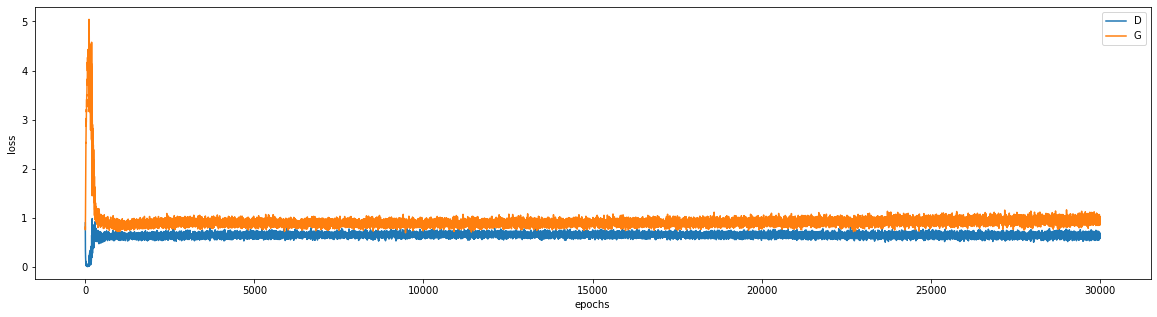

In [ ]:
import numpy as np
from keras.datasets import fashion_mnist




(X, _), (_, _) = fashion_mnist.load_data()
X_train = X / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)
print()
image_helper = ImageHelper()
generative_advarsial_network = GAN(X_train[0].shape, 100, image_helper)
generative_advarsial_network.train(30000, X_train, batch_size=32)

In [ ]:
%ls generated

0.png      13700.png  17600.png  21400.png  25300.png  29200.png  6100.png
10000.png  13800.png  17700.png  21500.png  25400.png  29300.png  6200.png
1000.png   13900.png  17800.png  21600.png  25500.png  29400.png  6300.png
100.png    14000.png  17900.png  21700.png  25600.png  29500.png  6400.png
10100.png  1400.png   18000.png  21800.png  25700.png  29600.png  6500.png
10200.png  14100.png  1800.png   21900.png  25800.png  29700.png  6600.png
10300.png  14200.png  18100.png  22000.png  25900.png  29800.png  6700.png
10400.png  14300.png  18200.png  2200.png   26000.png  29900.png  6800.png
10500.png  14400.png  18300.png  22100.png  2600.png   3000.png   6900.png
10600.png  14500.png  18400.png  22200.png  26100.png  300.png    7000.png
10700.png  14600.png  18500.png  22300.png  26200.png  3100.png   700.png
10800.png  14700.png  18600.png  22400.png  26300.png  3200.png   7100.png
10900.png  14800.png  18700.png  22500.png  26400.png  3300.png   7200.png
11000.png  14900.png  1880

In [ ]:
from IPython.display import Image
Image(open('generated/image.gif','rb').read())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
(X, _), (_, _) = fashion_mnist.load_data()
print(X.shape)
X_train = X / 127.5 - 1.
X_apein = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28)
(60000, 28, 28)
